In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from scipy import signal
from scipy.stats.stats import pearsonr

In [2]:
## Load Dataset
templates = []
keep_cols = ['EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']

def trim_cols(df, keep):
    return df[keep]

for i in range(1, 9):
    templates.append(trim_cols(pd.read_csv('templates/sultan_checkerboard_{}.csv'.format(i), skiprows=0, header=1), keep_cols))

In [3]:
# cutoff according to shortest length
cutoff = min([len(templates[i].index) for i in range(8)])
for i in range(8):
    keep_indicies = set(range(templates[i].shape[0])) - set(range(cutoff, templates[i].shape[0]))
    templates[i] = templates[i].take(list(keep_indicies))
    print('length of dataset {} = {}'.format(i+1, len(templates[i].index)))

length of dataset 1 = 3869
length of dataset 2 = 3869
length of dataset 3 = 3869
length of dataset 4 = 3869
length of dataset 5 = 3869
length of dataset 6 = 3869
length of dataset 7 = 3869
length of dataset 8 = 3869


In [4]:
def filter_template(template, offset_mode='average'):
    new_temp = template
    channels = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
    filt = signal.firwin(400, [0.01, 0.06], pass_zero=False)
    for channel in channels:
        N = len(template.index)
        if offset_mode == 'average':
            offset = np.average(np.array(template[channel]))
        elif offset_mode == 'minimum':
            offset = np.amin(np.array(template[channel]))
        elif offset_mode == 'same':
            offset = 3800
        elif offset_mode == 'none':
            offset = 0
        else:
            raise ValueError('choose a valid offset_mode')
        new_temp[channel] = [i - offset for i in template[channel]]
        new_temp[channel] = signal.convolve(new_temp[channel], filt, mode='same')
        
    # change timestamp to elapsed time
    # time0 = new_temp['Timestamp'][0]
    # new_temp['Timestamp'] = [i - time0 for i in new_temp['Timestamp']]
    
    return new_temp

In [5]:
for template in templates:
    template = filter_template(template, offset_mode='average')

In [6]:
def plot_time(template, xlim=1000):
    fig, (o1, o2, p7, p8) = plt.subplots(1, 4, figsize=(15,5))
    o1.plot(template['EEG.O1'])
    o1.set_title('O1')
    o1.set_xlim([0,xlim])
    o2.plot(template['EEG.O2'])
    o2.set_title('O2')
    o2.set_xlim([0,xlim])
    p7.plot(template['EEG.P7'])
    p7.set_title('P7')
    p7.set_xlim([0,xlim])
    p8.plot(template['EEG.P8'])
    p8.set_title('P8')
    p8.set_xlim([0,xlim])
    
    
    plt.show()

In [7]:
channels = ['EEG.O1', 'EEG.O2', 'EEG.P7', 'EEG.P8']
# templates[0].plot(x='Timestamp', y=channels)
# cutoff start and end samples
# Also the indicies that are cut off will not exist! The dataframe indicies will start at cutoff.
cutoff = 200
for template in templates:
    ind = [i for i in range(cutoff)] + [i for i in range(len(template.index)-1, len(template.index)-cutoff-1, -1)]
    template.drop(index=ind, inplace=True)

In [8]:
# plot

# for i, template in enumerate(templates):
#     ax = template.plot(x='Timestamp', y=channels, title='Target {}'.format(i+1))
    
# plot_time(templates[0], xlim=1000)

In [9]:
# average for each same EEG.Counter number - over all stimulus cycles
averages_all_targets = []

for template in templates:
    averages_for_target = []
    o1counters = []
    o2counters = []
    p7counters = []
    p8counters = []
    for i in range(129):
        o1counters.append([])
        o2counters.append([])
        p7counters.append([])
        p8counters.append([])
        
    for ind, row in template.iterrows():
        count_val = int(row['EEG.Counter'])
        o1counters[count_val].append(row['EEG.O1'])
        o2counters[count_val].append(row['EEG.O2'])
        p7counters[count_val].append(row['EEG.P7'])
        p8counters[count_val].append(row['EEG.P8'])
    
    for i in range(129):
        # find average for each counter value
        o1avg = np.average(np.array(o1counters[i]))
        o2avg = np.average(np.array(o2counters[i]))
        p7avg = np.average(np.array(p7counters[i]))
        p8avg = np.average(np.array(p8counters[i]))
        row = {'EEG.Counter': i, 'EEG.O1': o1avg, 'EEG.O2': o2avg, 'EEG.P7': p7avg, 'EEG.P8': p8avg}
        averages_for_target.append(row)
        
    averages_all_targets.append(pd.DataFrame(data=averages_for_target))
    # 129 length averages

In [10]:
def plot_ref(template, channel):
    # assume I have averages_all_targets
    # plot all targets of channel in same plot
    fig, ax = plt.subplots(figsize=(10,5))
    for sig in template:
        sig.plot(x='EEG.Counter', y=channel, ax=ax, title='{} Target Signals'.format(channel))
    ax.legend([str(i) for i in range(1, 9)])

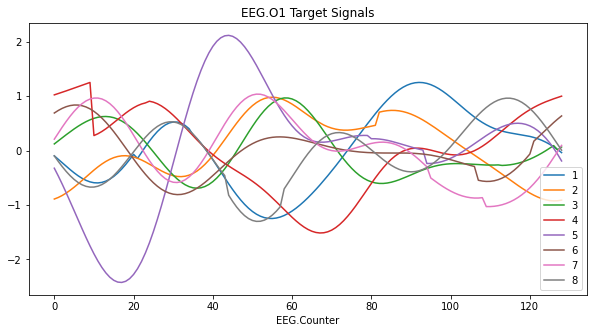

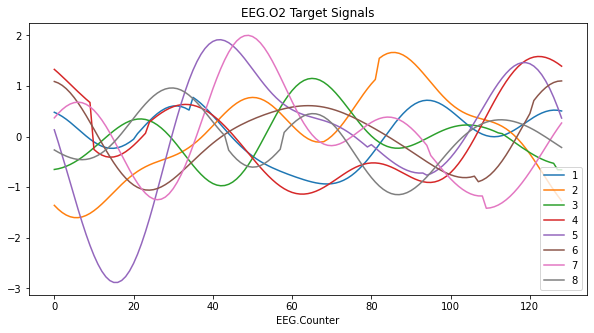

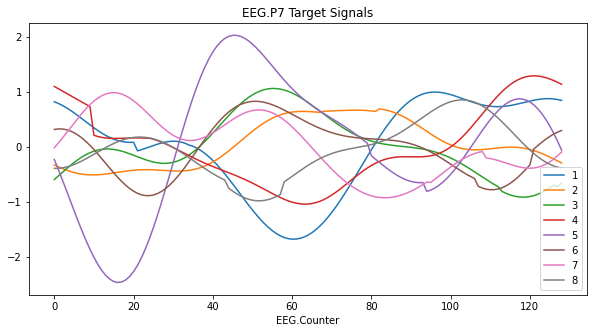

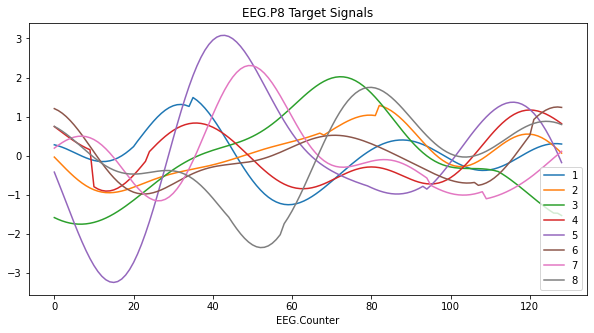

In [11]:
# plot all target signals on separate plots
# for sig in averages_all_targets:
#     plot_time(sig, xlim=130)

for channel in channels:
    plot_ref(averages_all_targets, channel)

In [12]:
# correlations
# take 1s - 128+1 samples of template[0] and correlate with each average in average_all_targets

def signal_correlation(test_signals, target_signals, verbose=False):
    # assume I have all averages
    corrs_o1 = []
    corrs_o2 = []
    corrs_p7 = []
    corrs_p8 = []
    for ref in target_signals:
        # pearsonr returns r (corr value) and p-value
        corr_o1 = pearsonr(np.array(test_signals['EEG.O1']), np.array(ref['EEG.O1']))
        corr_o2 = pearsonr(np.array(test_signals['EEG.O2']), np.array(ref['EEG.O2']))
        corr_p7 = pearsonr(np.array(test_signals['EEG.P7']), np.array(ref['EEG.P7']))
        corr_p8 = pearsonr(np.array(test_signals['EEG.P8']), np.array(ref['EEG.P8']))
        corrs_o1.append(corr_o1[0])
        corrs_o2.append(corr_o2[0])
        corrs_p7.append(corr_p7[0])
        corrs_p8.append(corr_p8[0])
        
    targeto1 = corrs_o1.index(max(corrs_o1))
    targeto2 = corrs_o2.index(max(corrs_o2))
    targetp7 = corrs_p7.index(max(corrs_p7))
    targetp8 = corrs_p8.index(max(corrs_p8))


    
    if verbose:
        print('Correlation Data:\n{}\n{}\n{}\n{}\n'.format(corrs_o1, corrs_o2, corrs_p7, corrs_p8))

    return (targeto1, targeto2, targetp7, targetp8)

In [13]:
# should start at EEG.Counter = 0?
# index = 165, next = 165 + 129 = 294
def test_correlation(targets, verbose=True):
    test0 = templates[0].query('294 < index < 294+130')
    test1 = templates[1].query('294 < index < 294+130')
    test2 = templates[2].query('294 < index < 294+130')
    test3 = templates[3].query('294 < index < 294+130')
    test4 = templates[4].query('294 < index < 294+130')
    test_vector = [test0, test1, test2, test3, test4]
    for i, test in enumerate(test_vector):
        to1, to2, tp7, tp8 = signal_correlation(test, targets, verbose=False)
        if verbose:
            print('Test target {}'.format(i))
            print('o1 : {}    o2 : {}    p7 : {}    p8 : {}\n'.format(to1, to2, tp7, tp8))
    return (to1, to2, tp7, tp8)

In [14]:
test_correlation(averages_all_targets)

Test target 0
o1 : 0    o2 : 7    p7 : 0    p8 : 0

Test target 1
o1 : 5    o2 : 5    p7 : 5    p8 : 5

Test target 2
o1 : 2    o2 : 7    p7 : 4    p8 : 4

Test target 3
o1 : 0    o2 : 0    p7 : 7    p8 : 7

Test target 4
o1 : 0    o2 : 5    p7 : 7    p8 : 7



(0, 5, 7, 7)

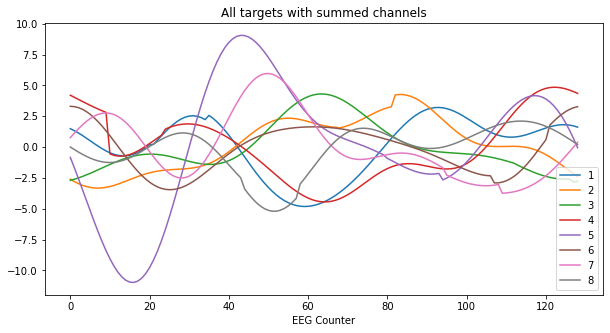

In [15]:
sum_refs = []
for i in range(8):
    sum_refs.append([])
for i, target in enumerate(averages_all_targets):
    for j in range(129):
        sum_refs[i].append(target['EEG.O1'][j] + target['EEG.O2'][j] + target['EEG.P7'][j] + target['EEG.P8'][j])
        
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(8):
    plt.xlabel('EEG Counter')
    plt.title('All targets with summed channels')
    plt.plot(sum_refs[i])
plt.legend([str(i) for i in range(1, 9)])

In [16]:
def two_signal_correlation(test_signal, target_signals):
    # check summed channel values - one test_signal compared with 8 target signals. which has highest correlation?
    corrs = []
    for ref in target_signals:
        corrs.append(pearsonr(np.array(test_signal), np.array(ref)))
        
    most_similar_target = corrs.index(max(corrs))
    return most_similar_target

In [17]:
# sum columns o1 o2 p7 p8
test0 = templates[0].query('294 < index < 294+130')[channels].sum(axis=1)
print(two_signal_correlation(test0, sum_refs))

3


In [18]:
test1 = templates[1].query('294 < index < 294+130')[channels].sum(axis=1)
print(two_signal_correlation(test1, sum_refs))

5


In [19]:
test2 = templates[2].query('294 < index < 294+130')[channels].sum(axis=1)
print(two_signal_correlation(test2, sum_refs))

4


In [20]:
# CCA
from sklearn.cross_decomposition import CCA
# n_components = channels = 4
cca = CCA(n_components=4)
# cca.fit(X, Y)
# X_transformed, Y_transformed = cca.transform(X, Y)